<a href="https://colab.research.google.com/github/arad1367/Instagram_NLP_project/blob/master/Instagram_Food_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP Notebook

<img src="https://raw.githubusercontent.com/arad1367/UniLi_sources/main/IMG/logo.jpg"
     alt="University of Liechtenstein"
     width="350"
     height="auto">

### About This Tutorial

This tutorial is prepared by **Dr. Pejman Ebrahimi** for the "Deep Learning and Advanced AI Techniques" course at the University of Liechtenstein.

For more resources and notebooks related to this course, please visit Moodle or GitHub repository: [Course Materials](https://github.com/arad1367/University-of-Liechtenstein/tree/main/Deep%20Learning%20and%20Advanced%20AI).

You can reach out to Dr. Pejman Ebrahimi via email: [pejman.ebrahimi@uni.li](mailto:pejman.ebrahimi@uni.li).

### Natural Language Processing with TensorFlow based on Instagram pages food review (A custom dataset)

- 1: Positive comments label
- 0: Negative comments label

### Check for GPU

In [1]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [2]:
import tensorflow as tf
print(tf.__version__)

2.18.0


### Get helper functions

In [3]:
# Download helper functions script
!wget https://raw.githubusercontent.com/arad1367/University-of-Liechtenstein/main/Deep%20Learning%20and%20Advanced%20AI/Session_4_DL_Advanced/helper_functions_tf.py

--2025-04-23 13:37:49--  https://raw.githubusercontent.com/arad1367/University-of-Liechtenstein/main/Deep%20Learning%20and%20Advanced%20AI/Session_4_DL_Advanced/helper_functions_tf.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10410 (10K) [text/plain]
Saving to: ‘helper_functions_tf.py.1’

helper_functions_tf 100%[===================>]  10.17K  --.-KB/s    in 0s      

2025-04-23 13:37:49 (60.4 MB/s) - ‘helper_functions_tf.py.1’ saved [10410/10410]



In [4]:
# Import series of helper functions for the notebook
from helper_functions_tf import create_tensorboard_callback, plot_loss_curves, compare_historys

### Download a text dataset

In [5]:
### data from my Github
import pandas as pd

!wget "https://raw.githubusercontent.com/arad1367/University-of-Liechtenstein/main/Deep%20Learning%20and%20Advanced%20AI/Session_4_DL_Advanced/Data_food.csv"
data = pd.read_csv('Data_food.csv')
data.head()

--2025-04-23 13:37:50--  https://raw.githubusercontent.com/arad1367/University-of-Liechtenstein/main/Deep%20Learning%20and%20Advanced%20AI/Session_4_DL_Advanced/Data_food.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32834 (32K) [text/plain]
Saving to: ‘Data_food.csv.2’

Data_food.csv.2     100%[===================>]  32.06K  --.-KB/s    in 0.01s   

2025-04-23 13:37:50 (3.02 MB/s) - ‘Data_food.csv.2’ saved [32834/32834]



,Comments,Label
0,I have taken it twice. It was really tasty and...,1
1,Wow!,1
2,This dish is an instant appetite suppressant.,0
3,Very beautiful!,1
4,Trash literally!,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Comments  1000 non-null   object
 1   Label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [7]:
# Split data to train and test datasets
bound = int(len(data) * 0.8)
train_df = data[:bound]
test_df = data[bound:]

In [8]:
len(train_df), len(test_df), train_df.isna().sum(), test_df.isna().sum()

(800,
 200,
 Comments    0
 Label       0
 dtype: int64,
 Comments    0
 Label       0
 dtype: int64)

In [9]:
# Shuffle training dataframe
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,Comments,Label
696,It's a small and interesting restaurant.,1
667,Don't eat us.,0
63,Wow. This is my heaven.,1
533,Who should I book for?,1
66,All of them was the same.,0


In [10]:
# Check some labels
train_df_shuffled['Comments'][70]

"I'd rather lick a dirty shoe than take a bite of this."

In [11]:
train_df_shuffled.head()

,Comments,Label
696,It's a small and interesting restaurant.,1
667,Don't eat us.,0
63,Wow. This is my heaven.,1
533,Who should I book for?,1
66,All of them was the same.,0


In [12]:
# The test data doesn't have a target
test_df.head()
test_df = test_df.drop("Label", axis=1)
test_df.tail()

,Comments
995,"I'm sorry, but this just doesn't look appetizi..."
996,You're a culinary genius!
997,Your culinary skills are truly impressive!
998,"I'm sorry, but this dish doesn't seem very app..."
999,It's disappointing to see a lack of attention ...


In [13]:
# How many examples of each class?
train_df.Label.value_counts(), len(train_df), train_df.dtypes

(Label
 1    574
 0    226
 Name: count, dtype: int64,
 800,
 Comments    object
 Label        int64
 dtype: object)

In [14]:
# How many total samples
len(train_df), len(test_df)

(800, 200)

In [15]:
# Let's visualize some random training examples >>> Use random to prevent Bias
import random
random_index = random.randint(0, len(train_df)-5) # create random indexes not higher than the total number of samples
for row in train_df_shuffled[["Comments", "Label"]][random_index:random_index+5].itertuples():
  _, comment, label = row
  print(f"Label: {label}", "(Positive comment)" if label > 0 else "(Negative comment)")
  print(f"Comment:\n{comment}\n")
  print("---\n")

Label: 1 (Positive comment)
Comment:
Delicious!

---

Label: 1 (Positive comment)
Comment:
Awww!

---

Label: 0 (Negative comment)
Comment:
It's very expensive.

---

Label: 1 (Positive comment)
Comment:
It's so yummy!

---

Label: 1 (Positive comment)
Comment:
I swear you are the best.

---



### Split data into training and validation sets

In [16]:
train_df_shuffled.head()

,Comments,Label
696,It's a small and interesting restaurant.,1
667,Don't eat us.,0
63,Wow. This is my heaven.,1
533,Who should I book for?,1
66,All of them was the same.,0


In [17]:
from sklearn.model_selection import train_test_split

x = train_df_shuffled['Comments'].to_numpy()
y = train_df_shuffled['Label'].to_numpy()

# Use train_test_split to split training data into training and validation sets
train_statement, valid_statement, train_label, valid_label = train_test_split(x,
                                                                              y,
                                                                              test_size=0.1,
                                                                              random_state=42)

In [18]:
len(train_statement), len(train_label), len(valid_statement), len(valid_label)

(720, 720, 80, 80)

In [19]:
# View the first 10 training sentences and their labels
train_statement[:10], train_label[:10]

(array(['Twenty!', 'I tried it. It was great.',
        'Pizza should be its own food group.',
        'Stop posting such tasty dishes!', 'I really love this meal.',
        'This meal is an insult to taste buds everywhere.',
        'This place is so nice.', "I'd rather throw it away.",
        'I wish I had lunch with you.', 'What a delicious cancer!'],
       dtype=object),
 array([1, 1, 1, 1, 1, 0, 1, 0, 1, 0]))

### Text vectorization (Tokenization)

In [20]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
# Note: in TensorFlow 2.6+, you no longer need "layers.experimental.preprocessing"
# you can use: "tf.keras.layers.TextVectorization", see https://github.com/tensorflow/tensorflow/releases/tag/v2.6.0 for more

# Use the default TextVectorization variables
text_vectorizer = TextVectorization(max_tokens=None, # how many words in the vocabulary (all of the different words in your text)
                                    standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    ngrams=None, # create groups of n-words?
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None) # how long should the output sequence of tokens be?
                                    # pad_to_max_tokens=True) # Not valid if using max_tokens=None

In [21]:
# Find average number of tokens (words) in training Tweets
import math
math.ceil(sum([len(i.split()) for i in train_statement])/len(train_statement))

6

In [22]:
# Setup and recreate text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary >> 32179 is common value
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [23]:
train_statement[:3], type(train_statement)

(array(['Twenty!', 'I tried it. It was great.',
        'Pizza should be its own food group.'], dtype=object),
 numpy.ndarray)

To `map` our TextVectorization instance `text_vectorizer` to our data, we can call the `adapt() method` on it whilst passing it our training text.

In [24]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_statement)

In [25]:
train_statement[10]

'I think the quality of the food has gone down and it is terrible.'

In [26]:
text_vectorizer([train_statement[10]])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  4, 122,   3,  36,  17,   3,  15, 132, 295, 673,   9,   2,   6,
        103,   0]])>

In [27]:
# Create sample sentence and tokenize it
# For example

sample_sentence = 'Iranian foods are amazing. just test them!'
text_vectorizer([sample_sentence]) # Text_vectorizer receive a list of sentences (A list of sequence)

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[580,   1,  20,  55,  60,   1,  73,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [28]:
# Choose a random sentence from the training dataset and tokenize it
import random

random_sentence = random.choice(train_statement)
print(f"""The original sentence is: {random_sentence}
      \nThe sentence after Vectorisation(Tokenisation) is: \n\n{text_vectorizer([random_sentence])}""")

The original sentence is: It's very crispy and delicious.
      
The sentence after Vectorisation(Tokenisation) is: 

[[ 10  33 700   9  18   0   0   0   0   0   0   0   0   0   0]]


Finally, we can check the unique tokens in our vocabulary using the `get_vocabulary()` method.

In [29]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5] # most common tokens (notice the [UNK] token for "unknown" words)
bottom_5_words = words_in_vocab[-5:] # least common tokens
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"Top 5 most common words: {top_5_words}")
print(f"Bottom 5 least common words: {bottom_5_words}")

Number of words in vocab: 799
Top 5 most common words: ['', '[UNK]', np.str_('it'), np.str_('the'), np.str_('i')]
Bottom 5 least common words: [np.str_('action'), np.str_('according'), np.str_('abroad'), np.str_('abomination'), np.str_('5')]


### Creating an Embedding using an Embedding Layer

In [30]:
from tensorflow.keras.layers import Embedding

max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15

embedding = Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # set size of embedding vector
                             embeddings_initializer="uniform", # default, intialize randomly
                             input_length=max_length, # how long is each input
                             name="embedding_1")

embedding

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


<Embedding name=embedding_1, built=False>

In [31]:
# Get a random sentence from training set
random_sentence = random.choice(train_statement)
print(f"Original text:\n{random_sentence}\
      \n\nEmbedded version:")

# Embed the random sentence (turn it into numerical representation)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
You speak beautifully.      

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.0083392 ,  0.03854766, -0.02820973, ...,  0.04526601,
          0.02504465,  0.03565499],
        [ 0.02577765, -0.03618572, -0.03100719, ...,  0.01215572,
          0.04093936, -0.00063732],
        [ 0.01861951, -0.02247969, -0.00040448, ..., -0.00241133,
         -0.02647643, -0.02259181],
        ...,
        [ 0.01545585,  0.03263637,  0.044388  , ..., -0.02384265,
         -0.01450205,  0.01783184],
        [ 0.01545585,  0.03263637,  0.044388  , ..., -0.02384265,
         -0.01450205,  0.01783184],
        [ 0.01545585,  0.03263637,  0.044388  , ..., -0.02384265,
         -0.01450205,  0.01783184]]], dtype=float32)>

In [32]:
# Check out a single token's embedding
sample_embed[0][0]

<tf.Tensor: shape=(128,), dtype=float32, numpy=
array([ 0.0083392 ,  0.03854766, -0.02820973,  0.01667638, -0.00277431,
       -0.00560325,  0.04447227,  0.0403021 , -0.01119436,  0.04918366,
        0.01602533, -0.0019437 , -0.02310841,  0.03553871, -0.01139605,
       -0.02929183, -0.00826253,  0.00174644,  0.02125392,  0.02497579,
       -0.01001598, -0.01785179, -0.02075869, -0.02302123,  0.00809066,
        0.01462125,  0.03568682, -0.01637329, -0.0091903 , -0.00324972,
       -0.00270794, -0.0144489 ,  0.0190254 ,  0.02127416,  0.04312018,
        0.00864735,  0.0429508 ,  0.04845908,  0.00530379, -0.00488322,
        0.04229904, -0.04522388, -0.00879935,  0.03414727,  0.00902555,
       -0.02640733, -0.00632029, -0.02125646,  0.03295486,  0.00414419,
       -0.02956157,  0.03032268,  0.02570042,  0.02183986,  0.04541579,
        0.03413567, -0.02413005,  0.04710689,  0.00728859, -0.00557871,
        0.00697911,  0.03286848, -0.0138647 , -0.00463989, -0.03408543,
       -0.029736

### Modelling a text dataset

### Model 0: Getting a baseline(Naive Bayes model with TF-IDF encoder)

In [33]:
# Required libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_statement, train_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [34]:
# Evaluate our baseline model
baseline_score = model_0.score(valid_statement, valid_label)
print(f'Our baseline model achieves an accuracy of: {baseline_score*100:0.2f}%')

Our baseline model achieves an accuracy of: 90.00%


In [35]:
# Make prediction
baseline_preds = model_0.predict(valid_statement)
baseline_preds[:20]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [36]:
import numpy as np

equality_percent = (np.mean(baseline_preds == valid_label))
print(f"The equality rate of y_preds and y_true is: {equality_percent*100:0.2f}%")

The equality rate of y_preds and y_true is: 90.00%


### Creating an evaluation function for our model experiments

In [37]:
# Function to evaluate: accuracy, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [38]:
# Get baseline results
baseline_results = calculate_results(y_true=valid_label,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 90.0,
 'precision': 0.9108108108108108,
 'recall': 0.9,
 'f1': 0.8828571428571429}

### Model 1: A simple dense model (Feed-forward neural network)

In [39]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions_tf import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [40]:
# Build model with the Functional API

inputs = tf.keras.layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = tf.keras.layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens. decrese in accuracy without it)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation, softmax for multi-class labels
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [41]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,280,129 (4.88 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [43]:
# Fit the model
model_1_history = model_1.fit(train_statement, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_label,
                              epochs=5,
                              validation_data=(valid_statement, valid_label),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20250423-133751
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.6606 - loss: 0.6391 - val_accuracy: 0.8250 - val_loss: 0.4596
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7116 - loss: 0.5795 - val_accuracy: 0.8250 - val_loss: 0.4605
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7025 - loss: 0.5789 - val_accuracy: 0.8375 - val_loss: 0.4655
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7157 - loss: 0.5517 - val_accuracy: 0.8375 - val_loss: 0.4519
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.7329 - loss: 0.5376 - val_accuracy: 0.8375 - val_loss: 0.4440


In [44]:
# Evaluate model_1
model_1_results = model_1.evaluate(valid_statement, valid_label)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.8016 - loss: 0.4764


In [45]:
model_1_results

[0.44404610991477966, 0.8374999761581421]

In [46]:
baseline_results

{'accuracy': 90.0,
 'precision': 0.9108108108108108,
 'recall': 0.9,
 'f1': 0.8828571428571429}

In [47]:
# Comparison of baseline model and model_1
print(f'The baseline model accuracy was: {baseline_results["accuracy"]:.2f}%, and dense model_1 accuracy is: {model_1_results[1]*100:.2f}%')

The baseline model accuracy was: 90.00%, and dense model_1 accuracy is: 83.75%


In [48]:
embedding.weights

[<Variable path=embedding_1/embeddings, shape=(10000, 128), dtype=float32, value=[[-0.06892275  0.11994124  0.13132498 ...  0.04369977 -0.10139637
   -0.06824971]
  [-0.00475291  0.04481255  0.00458582 ... -0.01005348  0.01857525
   -0.01397217]
  [ 0.01130504 -0.02272576 -0.03682392 ...  0.03740362  0.0355579
   -0.04124897]
  ...
  [-0.02561805 -0.0220553  -0.00655452 ... -0.00028244  0.01638066
    0.04248108]
  [-0.03790711  0.03486153 -0.0218443  ... -0.0149641  -0.00548733
   -0.01889343]
  [-0.00811921  0.01815096 -0.03430603 ...  0.03192398 -0.00957339
    0.04458192]]>]

In [49]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


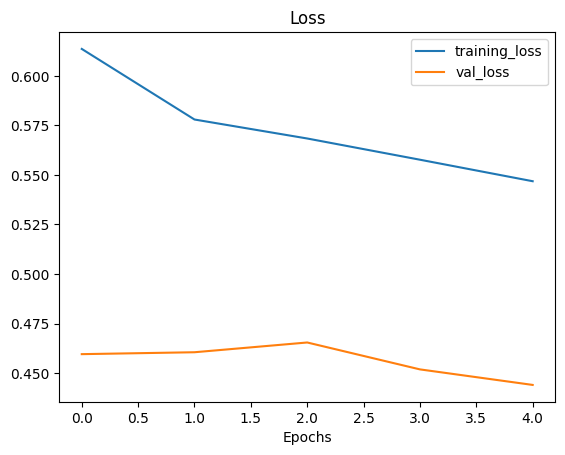

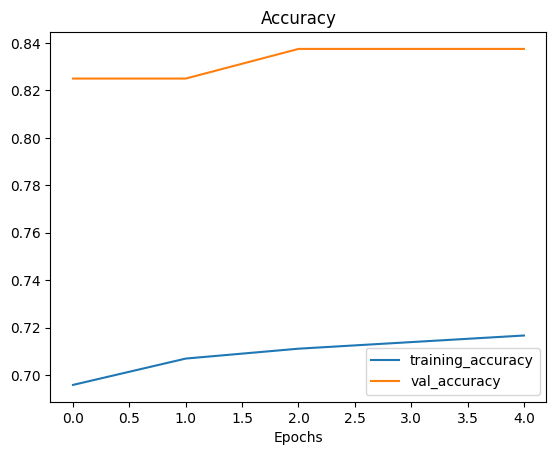

In [50]:
plot_loss_curves(model_1_history)

In [51]:
# Make predictions (these come back in the form of probabilities)
model_1_pred_probs = model_1.predict(valid_statement)
print(model_1_pred_probs.shape, model_1_pred_probs.ndim)
model_1_pred_probs[:10] # only print out the first 10 prediction probabilities

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
(80, 1) 2


array([[0.7856768 ],
       [0.7881365 ],
       [0.76495093],
       [0.7918911 ],
       [0.7409416 ],
       [0.726393  ],
       [0.7203184 ],
       [0.75226843],
       [0.71798974],
       [0.6242082 ]], dtype=float32)

In [52]:
# Turn prediction probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions
# In fact now our labes are 1 dim but pred is 2D, so we used sqeeze to reduce dimension >> (762,) and (762, 1)
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.], dtype=float32)>

In [53]:
valid_label[:20], valid_label.shape, valid_label.ndim

(array([1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]), (80,), 1)

In [54]:
print(f'The equality accuracy rate is: {(np.mean(model_1_preds==valid_label))*100:.2f}%')

The equality accuracy rate is: 83.75%


In [55]:
# Calculate model_1 metrics
model_1_results = calculate_results(y_true=valid_label,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 83.75,
 'precision': 0.864240506329114,
 'recall': 0.8375,
 'f1': 0.774367816091954}

In [56]:
# Check baseline metrics
baseline_results

{'accuracy': 90.0,
 'precision': 0.9108108108108108,
 'recall': 0.9,
 'f1': 0.8828571428571429}

In [57]:
# Is our simple Keras model better than our baseline model?
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [58]:
# Create a helper function to compare our baseline results to new model results
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

Baseline accuracy: 90.00, New accuracy: 83.75, Difference: -6.25
Baseline precision: 0.91, New precision: 0.86, Difference: -0.05
Baseline recall: 0.90, New recall: 0.84, Difference: -0.06
Baseline f1: 0.88, New f1: 0.77, Difference: -0.11


### Visualizing learned embeddings

In [59]:
# Get the vocabulary from the text vectorization layer
words_in_vocab = text_vectorizer.get_vocabulary()
print(f'Length of our vocabulary is: {len(words_in_vocab)}')
print(f'10 most repetitive words are: {words_in_vocab[:10]}')
print(f'10 less repetitive words are: {words_in_vocab[-10:]}')

Length of our vocabulary is: 799
10 most repetitive words are: ['', '[UNK]', np.str_('it'), np.str_('the'), np.str_('i'), np.str_('this'), np.str_('is'), np.str_('a'), np.str_('you'), np.str_('and')]
10 less repetitive words are: [np.str_('agree'), np.str_('ago'), np.str_('afford'), np.str_('advise'), np.str_('advertisement'), np.str_('action'), np.str_('according'), np.str_('abroad'), np.str_('abomination'), np.str_('5')]


In [60]:
model_1.summary()

Model: "model_1_dense"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,840,389 (14.65 MB)

 Trainable params: 1,280,129 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,560,260 (9.77 MB)

In [61]:
# Get the weight matrix of embedding layer
# (these are the numerical patterns between the text in the training dataset the model has learned)
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape) # same size as vocab size and embedding_dim (each word is a embedding_dim size vector)

(10000, 128)


### Embedding Projector

Tensorflow word embedding : https://www.tensorflow.org/text/guide/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk

Tensorflow embedding projector
https://projector.tensorflow.org/


In [62]:
# We need two files : vocabs and weights
words_in_vocab[:5], embed_weights.shape

(['', '[UNK]', np.str_('it'), np.str_('the'), np.str_('i')], (10000, 128))

In [63]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0:
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

In [64]:
# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Recurrent Neural Networks (RNN's)

### Model 2: LSTM

In [65]:
# Set random seed and create embedding layer (new embedding layer for each model)
# tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")


# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
# x = layers.LSTM(64, return_sequences=True)(x) # return vector for each word in the Tweet (you can stack RNN cells as long as return_sequences=True)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer on top of output of LSTM cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [66]:
# Get a summary
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [67]:
# Compile model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [68]:
# Get another summary
model_2.summary()

Model: "model_2_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,329,473 (5.07 MB)

 Trainable params: 1,329,473 (5.07 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Fit model
model_2_history = model_2.fit(train_statement,
                              train_label,
                              epochs=5,
                              validation_data=(valid_statement, valid_label),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20250423-133758
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.7193 - loss: 0.6324 - val_accuracy: 0.8250 - val_loss: 0.5043
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7200 - loss: 0.5773 - val_accuracy: 0.8375 - val_loss: 0.4662
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.7853 - loss: 0.4845 - val_accuracy: 0.9000 - val_loss: 0.2877
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.9366 - loss: 0.2257 - val_accuracy: 0.9000 - val_loss: 0.2780
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.9694 - loss: 0.1121 - val_accuracy: 0.8750 - val_loss: 0.3306


In [70]:
# Make predictions on the validation dataset
model_2_pred_probs = model_2.predict(valid_statement)
model_2_pred_probs.shape, model_2_pred_probs[:10] # view the first 10

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


((80, 1),
 array([[0.99268836],
        [0.72374815],
        [0.9893018 ],
        [0.98858386],
        [0.97173226],
        [0.9899436 ],
        [0.98934054],
        [0.99232984],
        [0.9154439 ],
        [0.96716315]], dtype=float32))

In [71]:
# Round out predictions and reduce to 1-dimensional array
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [72]:
# Calculate LSTM model results
model_2_results = calculate_results(y_true=valid_label,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 87.5, 'precision': 0.875, 'recall': 0.875, 'f1': 0.875}

In [73]:
# Compare model 2 to baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

Baseline accuracy: 90.00, New accuracy: 87.50, Difference: -2.50
Baseline precision: 0.91, New precision: 0.88, Difference: -0.04
Baseline recall: 0.90, New recall: 0.88, Difference: -0.03
Baseline f1: 0.88, New f1: 0.88, Difference: -0.01


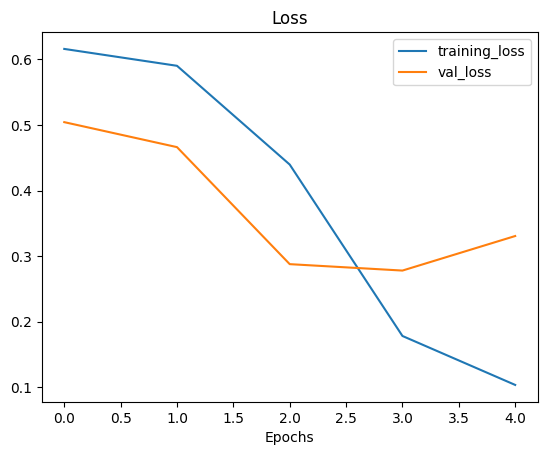

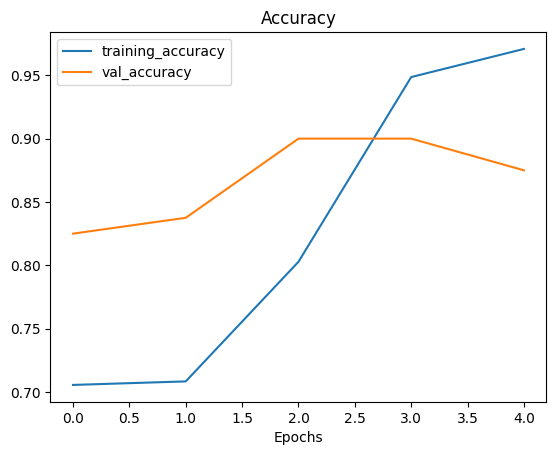

In [74]:
plot_loss_curves(model_2_history)

### Model 3: GRU

In [75]:
# Set random seed and create embedding layer (new embedding layer for each model)
# tf.random.set_seed(42)
model_3_embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
print(x.shape)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = tf.keras.layers.GRU(64)(x)
print(x.shape)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

(None, 15, 128)
(None, 64)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [76]:
# Get a summary of the model
model_3.summary()

Model: "model_3_GRU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_3 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,317,313 (5.03 MB)

 Trainable params: 1,317,313 (5.03 MB)

 Non-trainable params: 0 (0.00 B)

In [77]:
# Compile GRU model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

Notice the difference in number of trainable parameters between `model_2 (LSTM)` and `model_3 (GRU)`. The difference comes from the LSTM cell having more trainable parameters than the GRU cell.

We'll fit our model just as we've been doing previously. We'll also track our models results using our `create_tensorboard_callback()` function.

In [78]:
# Fit model
model_3_history = model_3.fit(train_statement,
                              train_label,
                              epochs=5,
                              validation_data=(valid_statement, valid_label),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20250423-133808
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6399 - loss: 0.6388 - val_accuracy: 0.8250 - val_loss: 0.4833
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.7089 - loss: 0.5961 - val_accuracy: 0.8250 - val_loss: 0.5009
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7142 - loss: 0.5914 - val_accuracy: 0.8375 - val_loss: 0.4663
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7663 - loss: 0.4998 - val_accuracy: 0.8625 - val_loss: 0.3289
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.9202 - loss: 0.1923 - val_accuracy: 0.8875 - val_loss: 0.2694


In [79]:
# Evaluate GRU model
model_3.evaluate(valid_statement, valid_label)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8734 - loss: 0.2902


[0.26936253905296326, 0.887499988079071]

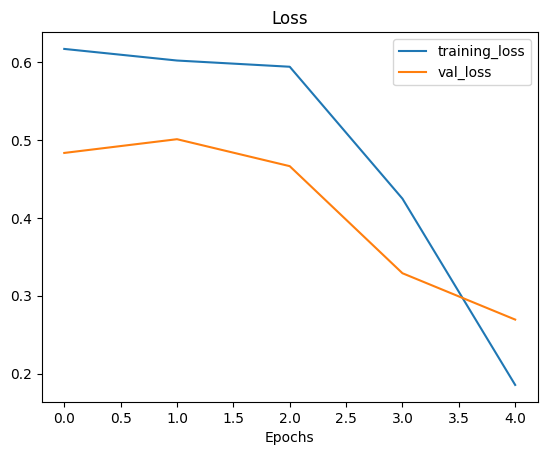

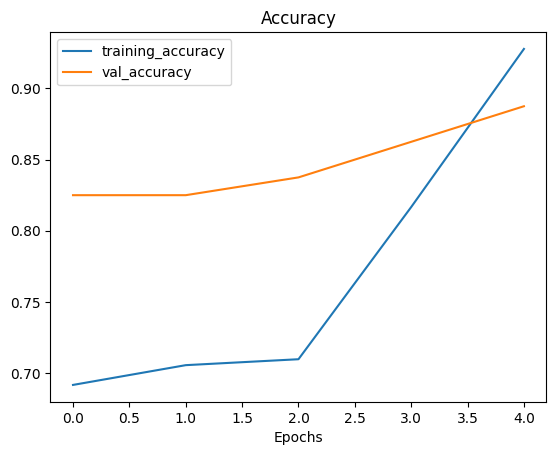

In [80]:
plot_loss_curves(model_3_history)

In [81]:
# Make predictions on the validation data
model_3_pred_probs = model_3.predict(valid_statement)
model_3_pred_probs.shape, model_3_pred_probs[:10]

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step


((80, 1),
 array([[0.9904288 ],
        [0.8039164 ],
        [0.9770003 ],
        [0.93592954],
        [0.8373722 ],
        [0.91349465],
        [0.94978863],
        [0.9893962 ],
        [0.6717925 ],
        [0.54282373]], dtype=float32))

In [82]:
# Convert prediction probabilities to prediction classes
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [83]:
# Calcuate model_3 results
model_3_results = calculate_results(y_true=valid_label,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 88.75,
 'precision': 0.8845866819747416,
 'recall': 0.8875,
 'f1': 0.8858395989974938}

In [84]:
# Compare to baseline
compare_baseline_to_new_results(baseline_results, model_3_results)

Baseline accuracy: 90.00, New accuracy: 88.75, Difference: -1.25
Baseline precision: 0.91, New precision: 0.88, Difference: -0.03
Baseline recall: 0.90, New recall: 0.89, Difference: -0.01
Baseline f1: 0.88, New f1: 0.89, Difference: 0.00


### Bidirectonal RNN model

In [85]:
# Set random seed and create embedding layer (new embedding layer for each model)
# tf.random.set_seed(42)
from tensorflow.keras import layers
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

# Build a Bidirectional RNN in TensorFlow
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
# x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(64))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs, outputs, name="model_4_Bidirectional")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


🔑 Note: You can use the Bidirectional wrapper on any RNN cell in TensorFlow. For example, `layers.Bidirectional(layers.GRU(64))` creates a bidirectional GRU cell.

Our bidirectional model is built, let's compile it.

In [86]:
# Compile
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [87]:
# Get a summary of our bidirectional model
model_4.summary()

Model: "model_4_Bidirectional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_4 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,378,945 (5.26 MB)

 Trainable params: 1,378,945 (5.26 MB)

 Non-trainable params: 0 (0.00 B)

In [88]:
# Fit the model (takes longer because of the bidirectional layers)
model_4_history = model_4.fit(train_statement,
                              train_label,
                              epochs=5,
                              validation_data=(valid_statement, valid_label),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20250423-133820
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - accuracy: 0.6288 - loss: 0.6368 - val_accuracy: 0.8250 - val_loss: 0.4982
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.7281 - loss: 0.5505 - val_accuracy: 0.8250 - val_loss: 0.4479
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.7494 - loss: 0.4960 - val_accuracy: 0.8625 - val_loss: 0.3620
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9079 - loss: 0.2712 - val_accuracy: 0.8375 - val_loss: 0.3922
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9275 - loss: 0.1695 - val_accuracy: 0.8875 - val_loss: 0.2669


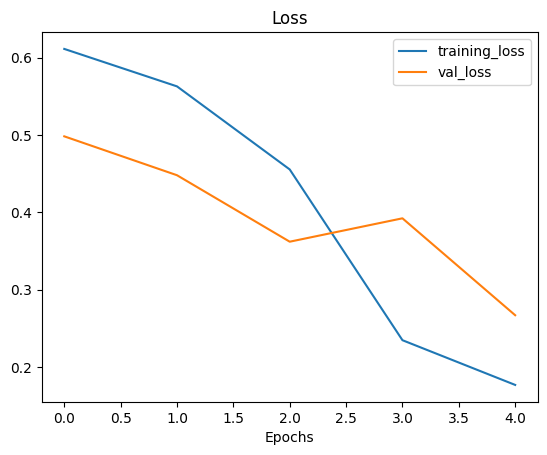

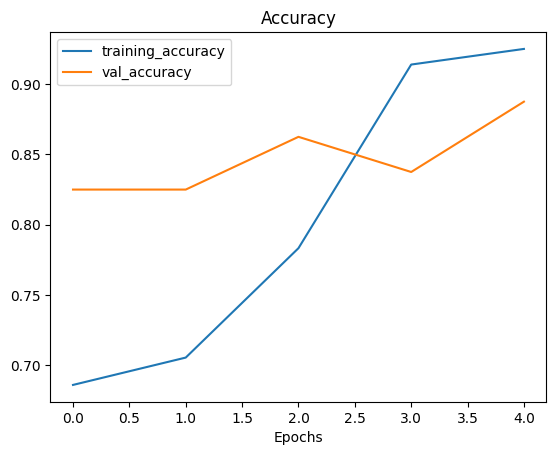

In [89]:
plot_loss_curves(model_4_history)

In [90]:
# Make predictions with bidirectional RNN on the validation data
model_4_pred_probs = model_4.predict(valid_statement)
model_4_pred_probs[:10]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step


array([[0.99725413],
       [0.86614305],
       [0.99239194],
       [0.93069816],
       [0.9123621 ],
       [0.9757512 ],
       [0.97612166],
       [0.99814385],
       [0.9611595 ],
       [0.95035386]], dtype=float32)

In [91]:
# Convert prediction probabilities to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [92]:
# Calculate bidirectional RNN model results
model_4_results = calculate_results(valid_label, model_4_preds)
model_4_results

{'accuracy': 88.75,
 'precision': 0.8805335968379447,
 'recall': 0.8875,
 'f1': 0.882}

#### Compare `LSTM model` with `Bidirectional LSTM model`

In [93]:
model_2_results

{'accuracy': 87.5, 'precision': 0.875, 'recall': 0.875, 'f1': 0.875}

In [94]:
model_4_results

{'accuracy': 88.75,
 'precision': 0.8805335968379447,
 'recall': 0.8875,
 'f1': 0.882}

In [95]:
# Check to see how the bidirectional model performs against the baseline
compare_baseline_to_new_results(baseline_results, model_4_results)

Baseline accuracy: 90.00, New accuracy: 88.75, Difference: -1.25
Baseline precision: 0.91, New precision: 0.88, Difference: -0.03
Baseline recall: 0.90, New recall: 0.89, Difference: -0.01
Baseline f1: 0.88, New f1: 0.88, Difference: -0.00


### Convolutional Neural Networks for Text

### Model 5: Conv1D
Before we build a full 1-dimensional CNN model, let's see a 1-dimensional convolutional layer (also called a `temporal convolution`) in action.

We'll first create an embedding of a sample of text and experiment passing it through a `Conv1D()` layer and `GlobalMaxPool1D()` layer.

In [96]:
# Test out the embedding, 1D convolutional and max pooling
from tensorflow.keras import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target sentence into embedding
conv_1d = layers.Conv1D(filters=32, kernel_size=5, activation="relu") # convolve over target sequence 5 words at a time
conv_1d_output = conv_1d(embedding_test) # pass embedding through 1D convolutional layer
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features
embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

Notice the output shapes of each layer.

The embedding has an output shape dimension of the parameters we set it to `(input_length=15 and output_dim=128)`.

The 1-dimensional convolutional layer has an output which has been compressed inline with its parameters. And the same goes for the max pooling layer output.

Our text starts out as a string but gets converted to a feature vector of length 64 through various transformation steps (from tokenization to embedding to 1-dimensional convolution to max pool).

Let's take a peak at what each of these transformations looks like.

In [97]:
# See the outputs of each layer
embedding_test[:1], conv_1d_output[:1], max_pool_output[:1]

(<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
 array([[[ 0.03947065, -0.01692745,  0.00993769, ..., -0.02057659,
           0.04351912, -0.00024447],
         [-0.03356687,  0.03372794,  0.07570323, ...,  0.06808516,
           0.00896119, -0.02564101],
         [ 0.02481321, -0.04102401,  0.01874542, ..., -0.05780437,
           0.0166846 ,  0.0257412 ],
         ...,
         [-0.06892275,  0.11994124,  0.13132498, ...,  0.04369977,
          -0.10139637, -0.06824971],
         [-0.06892275,  0.11994124,  0.13132498, ...,  0.04369977,
          -0.10139637, -0.06824971],
         [-0.06892275,  0.11994124,  0.13132498, ...,  0.04369977,
          -0.10139637, -0.06824971]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
 array([[[0.        , 0.0293064 , 0.00576636, 0.        , 0.        ,
          0.01048043, 0.        , 0.06612875, 0.00806667, 0.043767  ,
          0.04342168, 0.        , 0.        , 0.        , 0.        ,
          0.0847735 , 0.

Alright, we've seen the outputs of several components of a CNN for sequences, let's put them together and construct a full model, compile it (just as we've done with our other models) and get a summary.

In [98]:
# Set random seed and create embedding layer (new embedding layer for each model)
# tf.random.set_seed(42)
model_5_embedding = tf.keras.layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

# Create 1-dimensional convolutional layer to model sequences
inputs = tf.keras.layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

# Compile Conv1D model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Get a summary of our 1D convolution model
model_5.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_5_Conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization_1            │ (None, 15)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_5 (Embedding)         │ (None, 15, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 11, 32)         │        20,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 32)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,300,545 (4.96 MB)

 Trainable params: 1,300,545 (4.96 MB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Fit the model
model_5_history = model_5.fit(train_statement,
                              train_label,
                              epochs=5,
                              validation_data=(valid_statement, valid_label),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20250423-133834
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.5989 - loss: 0.6585 - val_accuracy: 0.8375 - val_loss: 0.4665
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.7089 - loss: 0.5781 - val_accuracy: 0.8500 - val_loss: 0.4612
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7411 - loss: 0.5261 - val_accuracy: 0.8625 - val_loss: 0.4213
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7987 - loss: 0.4442 - val_accuracy: 0.8375 - val_loss: 0.3966
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8817 - loss: 0.3601 - val_accuracy: 0.8750 - val_loss: 0.3141


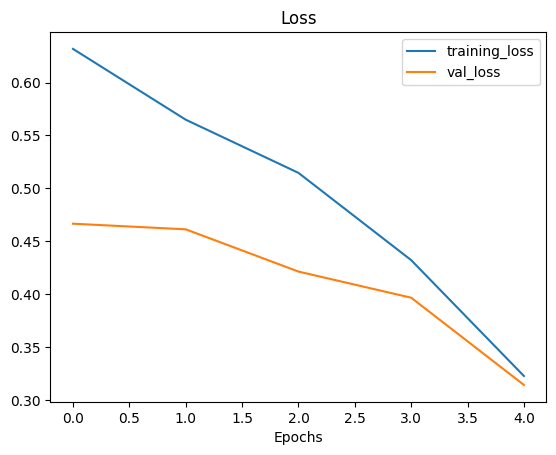

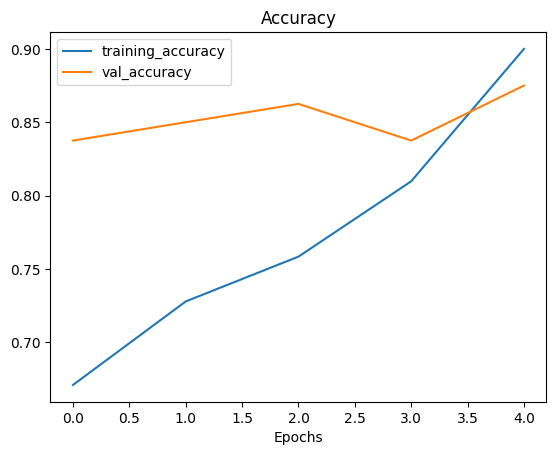

In [100]:
plot_loss_curves(model_5_history)

In [101]:
# Make predictions with model_5
model_5_pred_probs = model_5.predict(valid_statement)
model_5_pred_probs[:10]

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


array([[0.91640216],
       [0.8794604 ],
       [0.9059506 ],
       [0.8961455 ],
       [0.81359863],
       [0.92703766],
       [0.86927634],
       [0.88866013],
       [0.8733837 ],
       [0.8040939 ]], dtype=float32)

In [102]:
# Convert model_5 prediction probabilities to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)>

In [103]:
# Calculate model_5 evaluation metrics
model_5_results = calculate_results(y_true=valid_label,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 87.5,
 'precision': 0.8645833333333333,
 'recall': 0.875,
 'f1': 0.8606719367588933}

In [104]:
# Compare model_5 results to baseline
compare_baseline_to_new_results(baseline_results, model_5_results)

Baseline accuracy: 90.00, New accuracy: 87.50, Difference: -2.50
Baseline precision: 0.91, New precision: 0.86, Difference: -0.05
Baseline recall: 0.90, New recall: 0.88, Difference: -0.03
Baseline f1: 0.88, New f1: 0.86, Difference: -0.02


### Using Pretrained Embeddings (transfer learning for NLP) My favorite :)

### Model 6: TensorFlow Hub Pretrained Sentence Encoder
https://tfhub.dev/google/universal-sentence-encoder/4

In [105]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4") # load Universal Sentence Encoder
embed_samples = embed([sample_sentence,
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0][:50])

tf.Tensor(
[-0.01239911  0.00531641  0.00797472 -0.03804583  0.01240789 -0.00810601
  0.0091806   0.00438819 -0.08793548  0.03114571 -0.02497367 -0.04665659
  0.00771848 -0.00802412 -0.08866692  0.0074163   0.03054637 -0.03240824
  0.07602613 -0.02934266 -0.04387604  0.02580049 -0.04796465  0.03009111
 -0.01229549 -0.05937985 -0.03759459  0.05144268 -0.00768851  0.02472853
 -0.02116947  0.05947938 -0.07611944  0.0674796   0.01076261  0.06530146
 -0.07631268 -0.08424358  0.02060567 -0.00485047 -0.05268645  0.00759981
  0.06253339  0.00515983 -0.06616408 -0.02195467  0.02018192  0.02591529
  0.05857546 -0.0091106 ], shape=(50,), dtype=float32)


In [106]:
# Each sentence has been encoded into a 512 dimension vector
embed_samples[0].shape

TensorShape([512])

In [107]:
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # shape of inputs coming to our model
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE")

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers, Model

# Define a custom Keras layer that wraps the USE model
class USELayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(USELayer, self).__init__(**kwargs)
        self.use = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

    def call(self, inputs):
        return self.use(inputs)

# Define the input layer
inputs = tf.keras.Input(shape=(), dtype=tf.string)

# Pass the inputs through the custom USE layer
x = USELayer()(inputs)

# Add additional layers
x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# Define the model
model_6 = Model(inputs=inputs, outputs=outputs, name="model_6_USE")

# Compile the model
model_6.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Display the model summary
model_6.summary()


Model: "model_6_USE"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None)                 │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ use_layer (USELayer)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,897 (128.50 KB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 0 (0.00 B)

In [109]:
# Train a classifier on top of pretrained embeddings
model_6_history = model_6.fit(train_statement,
                              train_label,
                              epochs=5,
                              validation_data=(valid_statement, valid_label),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20250423-133926
Epoch 1/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 158ms/step - accuracy: 0.6657 - loss: 0.6509 - val_accuracy: 0.8250 - val_loss: 0.4762
Epoch 2/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.7303 - loss: 0.5071 - val_accuracy: 0.8875 - val_loss: 0.3532
Epoch 3/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8528 - loss: 0.3904 - val_accuracy: 0.9500 - val_loss: 0.2856
Epoch 4/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9128 - loss: 0.2899 - val_accuracy: 0.9500 - val_loss: 0.2307
Epoch 5/5
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9375 - loss: 0.2336 - val_accuracy: 0.9625 - val_loss: 0.1923


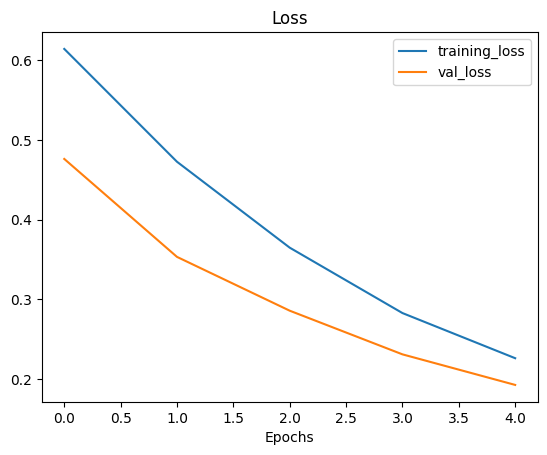

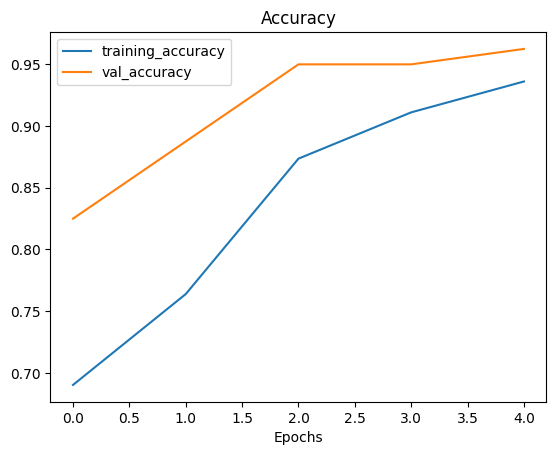

In [110]:
plot_loss_curves(model_6_history)

In [111]:
# Make predictions with USE TF Hub model
model_6_pred_probs = model_6.predict(valid_statement)
model_6_pred_probs[:10]

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 222ms/step


array([[0.987507  ],
       [0.18196788],
       [0.9189823 ],
       [0.93930864],
       [0.8276151 ],
       [0.8401506 ],
       [0.8292997 ],
       [0.9891859 ],
       [0.9259772 ],
       [0.33354717]], dtype=float32)

In [112]:
# Convert prediction probabilities to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 0., 1., 1., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [113]:
# Calculate model 6 performance metrics
model_6_results = calculate_results(valid_label, model_6_preds)
model_6_results

{'accuracy': 96.25,
 'precision': 0.9639743589743588,
 'recall': 0.9625,
 'f1': 0.9630034219531455}

In [114]:
# Compare TF Hub model to baseline
compare_baseline_to_new_results(baseline_results, model_6_results)

Baseline accuracy: 90.00, New accuracy: 96.25, Difference: 6.25
Baseline precision: 0.91, New precision: 0.96, Difference: 0.05
Baseline recall: 0.90, New recall: 0.96, Difference: 0.06
Baseline f1: 0.88, New f1: 0.96, Difference: 0.08


### Comparing the performance of each of our models

In [115]:
type(baseline_results)

dict

In [116]:
# Combine model results(dictionaries) into a DataFrame
all_model_results = pd.DataFrame({"baseline": baseline_results,
                                  "simple_dense": model_1_results,
                                  "lstm": model_2_results,
                                  "gru": model_3_results,
                                  "bidirectional": model_4_results,
                                  "conv1d": model_5_results,
                                  "tf_hub_sentence_encoder": model_6_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
baseline,90.00,0.910811,0.9000,0.882857
simple_dense,83.75,0.864241,0.8375,0.774368
lstm,87.50,0.875000,0.8750,0.875000
gru,88.75,0.884587,0.8875,0.885840
bidirectional,88.75,0.880534,0.8875,0.882000
conv1d,87.50,0.864583,0.8750,0.860672
tf_hub_sentence_encoder,96.25,0.963974,0.9625,0.963003


In [117]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100

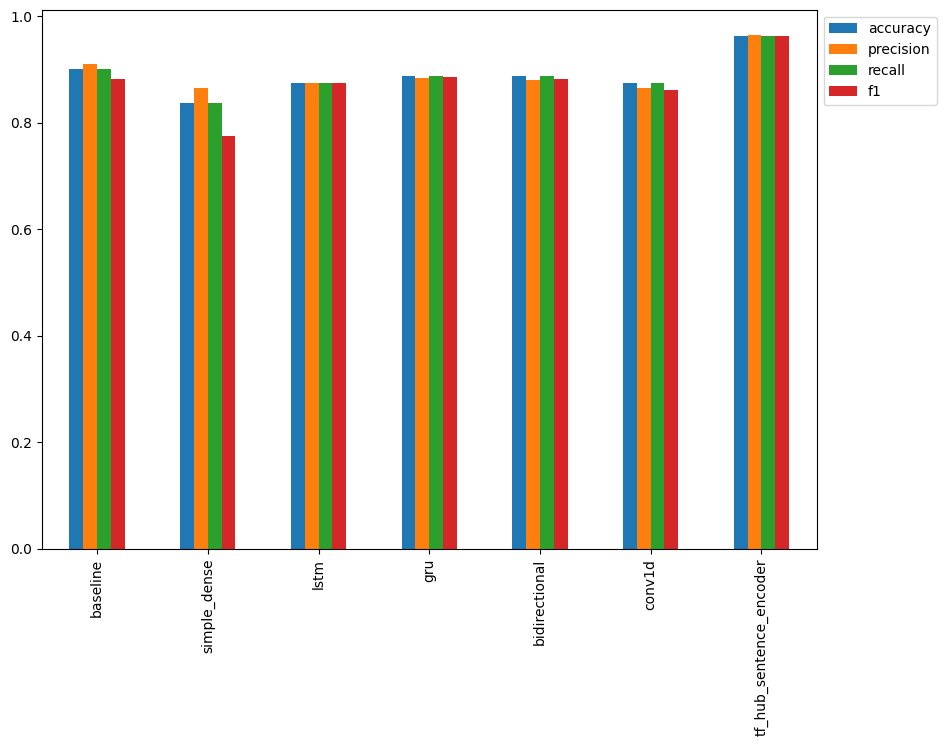

In [118]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

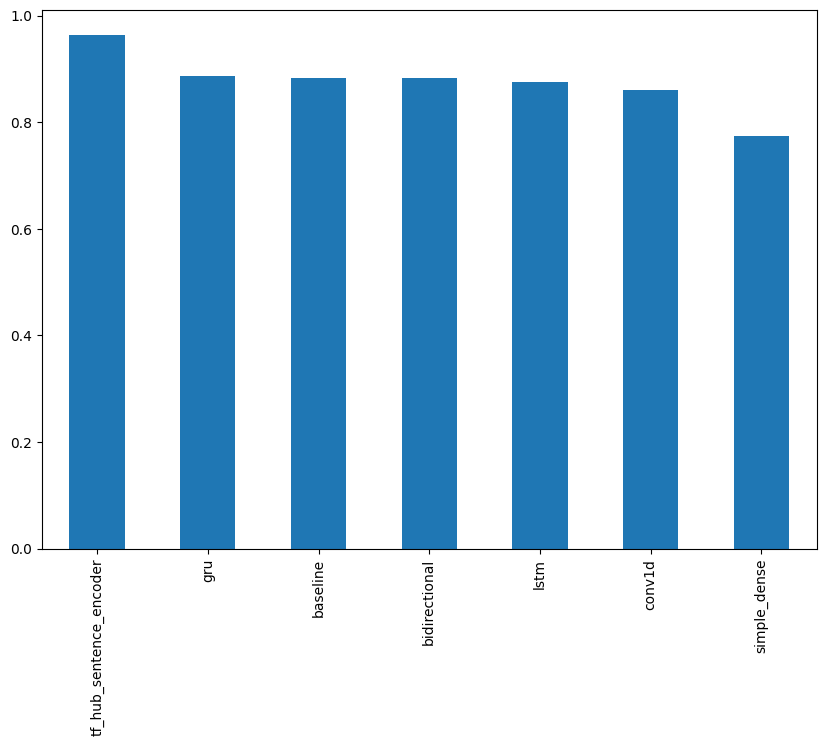

In [119]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

In [122]:
# Get mean pred probs for 3 models
baseline_pred_probs = np.max(model_0.predict_proba(valid_statement), axis=1) # get the prediction probabilities from baseline model
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_probs, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3) # average and round the prediction probabilities to get prediction classes
combined_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.,
       1., 1., 1.], dtype=float32)>

Wonderful! We've got a combined predictions array of different classes, let's evaluate them against the true labels and add our stacked model's results to our all_model_results DataFrame.

In [123]:
# Calculate results from averaging the prediction probabilities
ensemble_results = calculate_results(valid_label, combined_preds)
ensemble_results

{'accuracy': 90.0,
 'precision': 0.8955882352941178,
 'recall': 0.9,
 'f1': 0.8969001148105626}

In [124]:
# Add our combined model's results to the results DataFrame
all_model_results.loc["ensemble_results"] = ensemble_results

In [125]:
# Convert the accuracy to the same scale as the rest of the results
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100

<ipython-input-125-eb0b96b5da6e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100


In [126]:
all_model_results

,accuracy,precision,recall,f1
baseline,0.9000,0.910811,0.9000,0.882857
simple_dense,0.8375,0.864241,0.8375,0.774368
lstm,0.8750,0.875000,0.8750,0.875000
gru,0.8875,0.884587,0.8875,0.885840
bidirectional,0.8875,0.880534,0.8875,0.882000
conv1d,0.8750,0.864583,0.8750,0.860672
tf_hub_sentence_encoder,0.9625,0.963974,0.9625,0.963003
ensemble_results,90.0000,0.895588,0.9000,0.896900


### Saving and loading a trained model

In [127]:
model_6_results

{'accuracy': 96.25,
 'precision': 0.9639743589743588,
 'recall': 0.9625,
 'f1': 0.9630034219531455}

In [128]:
# Save TF Hub Sentence Encoder model to HDF5 format
model_6.save("model_6.h5")

If you save a model as a `HDF5`, when loading it back in, you need to let TensorFlow know about any custom objects you've used (e.g. components which aren't built from pure TensorFlow, such as TensorFlow Hub components).
https://www.tensorflow.org/tutorials/keras/save_and_load#saving_custom_objects

In [131]:
# Load model with custom Hub Layer (required with HDF5 format)

from tensorflow.keras.models import load_model

# Ensure USELayer is defined in the current scope
loaded_model = load_model("model_6.h5", custom_objects={"USELayer": USELayer})


In [133]:
# How does our loaded model perform?
loaded_model.evaluate(valid_statement, valid_label)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.9773 - loss: 0.1787


[0.1923106163740158, 0.9624999761581421]

In [134]:
model_6_results

{'accuracy': 96.25,
 'precision': 0.9639743589743588,
 'recall': 0.9625,
 'f1': 0.9630034219531455}

Tensorflow documentation for save model
https://www.tensorflow.org/tutorials/keras/save_and_load

### Finding the most wrong examples from our outputs

In [136]:
# Create dataframe with validation sentences and best performing model predictions
val_df = pd.DataFrame({"text": valid_statement,
                       "target": valid_label,
                       "pred": model_6_preds,
                       "pred_prob": tf.squeeze(model_6_pred_probs)}) # Without tf.round
val_df.head()

,text,target,pred,pred_prob
0,Awesome as always.,1,1.0,0.987507
1,Nah.,0,0.0,0.181968
2,So easy and good.,1,1.0,0.918982
3,Exactly!,1,1.0,0.939309
4,I just got hungry.,1,1.0,0.827615


Oh yeah! Now let's find our model's wrong predictions `(where target != pred)` and `sort` them by their prediction probability (the `pred_prob column`).

In [137]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob", ascending=False)
most_wrong[:10]

,text,target,pred,pred_prob
36,Why don't you use a plate and a spoon or a fork?,0,1.0,0.551337
71,It tastes like heaven.,1,0.0,0.479755
67,Why does this look so mouth-watering?,1,0.0,0.376663


In [138]:
# Check the false positives (model predicted 1 when should've been 0)
for row in most_wrong[:10].itertuples(): # loop through the top 10 rows (change the index to view different rows)
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.5513368248939514
Text:
Why don't you use a plate and a spoon or a fork?

----

Target: 1, Pred: 0, Prob: 0.4797554314136505
Text:
It tastes like heaven.

----

Target: 1, Pred: 0, Prob: 0.37666305899620056
Text:
Why does this look so mouth-watering?

----



We can view the bottom end of our most_wrong DataFrame to inspect false negatives (model predicts 0, Negative comment, when it should've predicted 1, positive comment).

In [139]:
# Check the most wrong false negatives (model predicted 0 when should've predict 1)
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, prob = row
  print(f"Target: {target}, Pred: {int(pred)}, Prob: {prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target: 0, Pred: 1, Prob: 0.5513368248939514
Text:
Why don't you use a plate and a spoon or a fork?

----

Target: 1, Pred: 0, Prob: 0.4797554314136505
Text:
It tastes like heaven.

----

Target: 1, Pred: 0, Prob: 0.37666305899620056
Text:
Why does this look so mouth-watering?

----



### Making predictions on the test dataset
Alright we've seen how our model's perform on the validation set.

But how about the test dataset?

We don't have labels for the test dataset so we're going to have to make some predictions and inspect them for ourselves.

Let's write some code to make predictions on random samples from the test dataset and visualize them.

In [143]:
import numpy as np
import tensorflow as tf
import random

test_sentences = test_df["Comments"].to_list()
test_samples = random.sample(test_sentences, 10)

for test_sample in test_samples:
    # Convert the input to a NumPy array with dtype=object
    input_array = np.array([test_sample], dtype=object)

    # Make prediction
    pred_prob = tf.squeeze(loaded_model.predict(input_array))
    pred = tf.round(pred_prob)

    print(f"Pred: {int(pred)}, Prob: {pred_prob}")
    print(f"Comment:\n{test_sample}\n")
    print("----\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
Pred: 1, Prob: 0.5442250370979309
Comment:
I wish I could take a bite through the screen!

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Pred: 1, Prob: 0.8729750514030457
Comment:
Pizza is my one true love.

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Pred: 1, Prob: 0.9343454837799072
Comment:
Ice cream, my forever love.

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Pred: 0, Prob: 0.47663626074790955
Comment:
The portion size seems quite small; perhaps a larger serving would be better.

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Pred: 1, Prob: 0.6589282155036926
Comment:
That burger is a work of art.

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Pred: 0, Prob: 0.43049001693725586
Comment:
I've had better-looking meals at home.

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Pred: 1, Prob: 0.8822449445724487
Comment:
I can't resist hitting the 'save' button on your recipes. Yum!

----

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Pred: 1, Prob: 0.58735859394073

### Predicting on Instagram comments from a custom comment


In [148]:
# Turn Tweet into string
pejman_comment = "It is my favorite dish."

In [149]:
import numpy as np
import tensorflow as tf

def predict_comment(comment, model):
    """
    Predicts the sentiment of a given comment using the provided model.

    Parameters:
    - comment (str): The input comment to analyze.
    - model (tf.keras.Model): The trained Keras model for prediction.

    Returns:
    - pred (int): The predicted class label (0 or 1).
    - pred_prob (float): The probability associated with the positive class.
    """
    # Convert the input comment to a NumPy array with dtype=object
    input_array = np.array([comment], dtype=object)

    # Obtain the prediction probability
    pred_prob = tf.squeeze(model.predict(input_array))

    # Round the probability to get the predicted class
    pred = tf.round(pred_prob)

    return int(pred), float(pred_prob)


In [150]:
# Make a prediction on Tweet from the wild
predict_comment(model=model_6, # use the USE model
                    comment=pejman_comment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


(1, 0.9696006774902344)

### make a Gradio app

In [151]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00


In [154]:
import numpy as np
import tensorflow as tf

def predict_comment(comment):
    """
    Predicts the sentiment of a given comment using the loaded model.

    Parameters:
    - comment (str): The input comment to analyze.

    Returns:
    - str: A formatted string indicating the sentiment and associated probability.
    """
    # Convert the input comment to a NumPy array with dtype=object
    input_array = np.array([comment], dtype=object)

    # Obtain the prediction probability
    pred_prob = tf.squeeze(loaded_model.predict(input_array))

    # Round the probability to get the predicted class
    pred = tf.round(pred_prob).numpy()

    # Map the prediction to a sentiment label
    sentiment = "Positive Comment" if pred == 1 else "Negative Comment"

    return f"{sentiment} (Probability: {pred_prob:.4f})"


In [155]:
import gradio as gr

# Create the Gradio interface
demo = gr.Interface(
    fn=predict_comment,
    inputs=gr.Textbox(lines=2, placeholder="Enter a comment here..."),
    outputs="text",
    title="Sentiment Analysis with USE - By Pejman :)",
    description="Enter a comment related to quality of food to predict its sentiment."
)

# Launch the app
demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://46bab623dce209dd5b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
